# News Articles Data Mining Notebook

In this notebook we are going to deal with data from various news articles of diggerent kinds(business,
entertainment, politics, sport and tech). We are going to create wordclouds, and perform classification and clustering for our data.

## Import Libraries


In [1]:
## Ignoring unnecessory warnings
import warnings
warnings.filterwarnings("ignore")  
# Specialized container datatypes
import collections
# For Map vizualization
import folium
from nltk.corpus import genesis
# For data vizualization 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# For large and multi-dimensional arrays
import numpy as np
# For data manipulation and analysis
import pandas as pd
# Natural language processing library
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.collocations import (
    BigramAssocMeasures,
    BigramCollocationFinder)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
# For random selection 
import random
# For basic cleaning and data preprocessing 
import re
import string 
# Communicating with operating and file system
import os
# Machine learning libary
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
# For wordcloud generating 
from wordcloud import WordCloud
nltk.download('genesis')
from PIL import Image, ImageOps

[nltk_data] Downloading package stopwords to /home/nikos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nikos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package genesis to /home/nikos/nltk_data...
[nltk_data]   Package genesis is already up-to-date!


## Create and load datasets

Given a directory with all the data, we create 2 different data frames; one for training our algorithms, and one for testing. We use a python script that we created, and can be found in the parent directory of the project

In [8]:
%run create_dataset.py --dir data
TEST_DATASET = "./test_set.tsv"
TRAIN_DATASET = "./train_set.tsv"
test_df = pd.read_csv(TEST_DATASET, sep='\t')
train_df = pd.read_csv(TRAIN_DATASET, sep='\t')

---------------------- Constructing dataset ----------------------

Running with the following configuration
	 dir --> data
	 out --> dataset.tsv

Creating datasets...
	An error occured on reading file: /home/nikos/Desktop/6th Semester/Data Mining/Projects/News-Articles-Classification/data/sport/199.txt
Datasets creating completed successfully. Time elapsed: 0.623 seconds


Let's look at the dataset info to see if everything is alright.

In [9]:
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1779 entries, 0 to 1778
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        1779 non-null   int64 
 1   Title     1779 non-null   object
 2   Content   1779 non-null   object
 3   Category  1779 non-null   object
dtypes: int64(1), object(3)
memory usage: 55.7+ KB


,Id,Title,Content,Category
0,1542,UK youth 'interested' in politics\n,\nThe majority of young people are interested ...,politics
1,2012,Pavey focuses on indoor success\n,\nJo Pavey will miss January's View From Great...,sport
2,1183,Spike Lee backs student directors\n,\nFilm-maker Spike Lee says black representati...,entertainment
3,713,Delta cuts fares in survival plan\n,\nDelta Air Lines is cutting domestic fares by...,business
4,1952,Moya clinches Cup for Spain\n,\nSpain won the Davis Cup for the second time ...,sport


## Wordclouds

We are going to create one wordcloud for each category

### Buisness articles

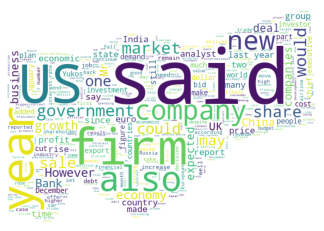

In [14]:
maskImageArray = np.array(Image.open("wordcloud_masks/business.png"))
stop_words = nltk.corpus.stopwords.words('english')
buisness_wordcloud = WordCloud(max_words=1000,mask=maskImageArray, background_color="white", stopwords=stop_words).generate(' '.join(train_df.loc[train_df['Category'] == 'business']['Content'].tolist()))
plt.imshow(buisness_wordcloud)
plt.axis('off')
plt.show()

### Entertainment articles

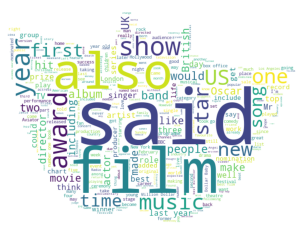

In [15]:
maskImageArray = np.array(Image.open("wordcloud_masks/entairtenment.png"))
stop_words = nltk.corpus.stopwords.words('english')
ent_wordcloud = WordCloud(max_words=1000,mask=maskImageArray, background_color="white", stopwords=stop_words).generate(' '.join(train_df.loc[train_df['Category'] == 'entertainment']['Content'].tolist()))
plt.imshow(ent_wordcloud)
plt.axis('off')
plt.show()

### Politics articles


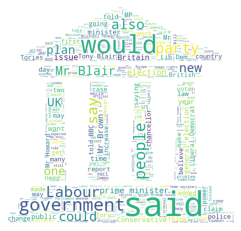

In [29]:
maskImageArray = np.array(Image.open("wordcloud_masks/politics.png"))
stop_words = nltk.corpus.stopwords.words('english')
pol_wordcloud = WordCloud(max_words=1000,mask=maskImageArray, background_color="white", stopwords=stop_words).generate(' '.join(train_df.loc[train_df['Category'] == 'politics']['Content'].tolist()))
plt.imshow(pol_wordcloud)
plt.axis('off')
plt.show()

### Sports articles

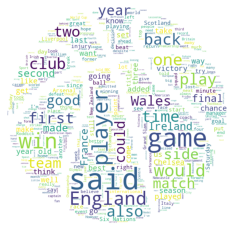

In [33]:
maskImageArray = np.array(Image.open("wordcloud_masks/sports1.png"))
stop_words = nltk.corpus.stopwords.words('english')
sport_wordcloud = WordCloud(max_words=1000,mask=maskImageArray, background_color="white", stopwords=stop_words).generate(' '.join(train_df.loc[train_df['Category'] == 'sport']['Content'].tolist()))
plt.imshow(sport_wordcloud)
plt.axis('off')
plt.show()

### Tech articles

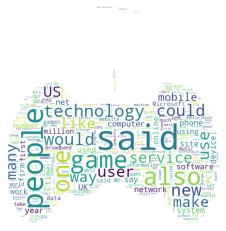

In [39]:
maskImageArray = np.array(Image.open("wordcloud_masks/tech.png"))
stop_words = nltk.corpus.stopwords.words('english')
tech_wordcloud = WordCloud(max_words=1000,mask=maskImageArray, background_color="white", stopwords=stop_words).generate(' '.join(train_df.loc[train_df['Category'] == 'tech']['Content'].tolist()))
plt.imshow(tech_wordcloud)
plt.axis('off')
plt.show()